# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

In [12]:
import nltk
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
nltk.download('brown')
from nltk.corpus import brown

[nltk_data] Downloading package brown to
[nltk_data]     /Users/algavkovskii/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [13]:
words = brown.words()
print(f"Total words in Brown corpus: {len(words)}")

word_freq = Counter(words)
unique_words_count = len(word_freq)
print(f"Unique words: {unique_words_count}")
words

Total words in Brown corpus: 1161192
Unique words: 56057


['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', ...]

In [14]:
sorted_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
frequencies = [f for w, f in sorted_words]

total_freq = sum(frequencies)
cumulative = np.cumsum(frequencies) / total_freq

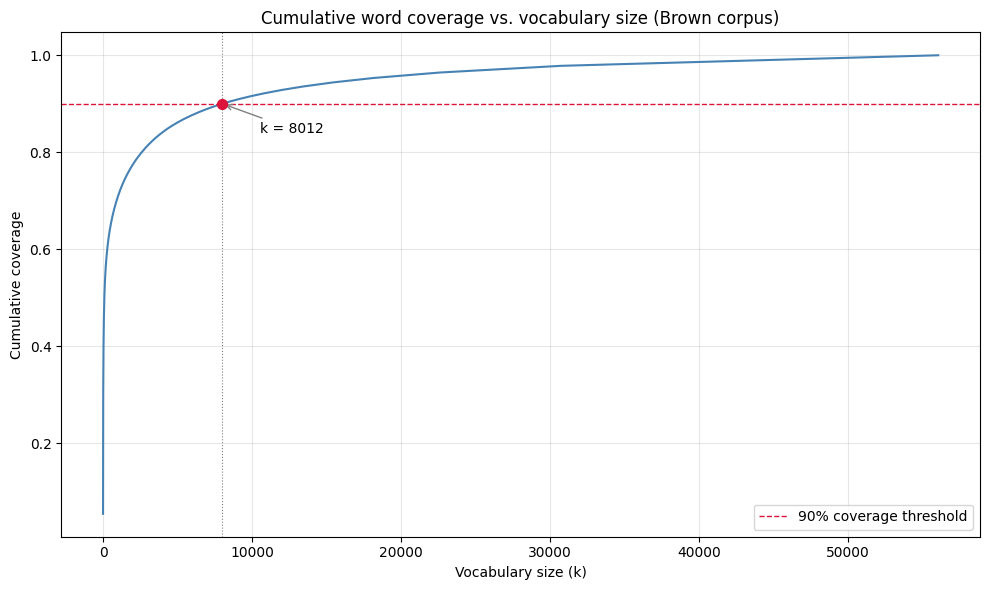

Minimal vocabulary size for >= 90% coverage: 8012


In [15]:
k_90 = next(i for i, cov in enumerate(cumulative, start=1) if cov >= 0.9)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative) + 1), cumulative, color='steelblue', linewidth=1.5)
plt.axhline(y=0.9, color='crimson', linestyle='--', linewidth=1, label='90% coverage threshold')
plt.axvline(x=k_90, color='gray', linestyle=':', linewidth=0.8)
plt.scatter([k_90], [0.9], color='crimson', zorder=5, s=50)
plt.annotate(f'k = {k_90}', xy=(k_90, 0.9), xytext=(k_90 + 2500, 0.84),
             arrowprops=dict(arrowstyle='->', color='gray'), fontsize=10)
plt.xlabel('Vocabulary size (k)')
plt.ylabel('Cumulative coverage')
plt.title('Cumulative word coverage vs. vocabulary size (Brown corpus)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Minimal vocabulary size for >= 90% coverage: {k_90}")

### Task 1 — Answers

**Q1: Why does coverage slow down as vocabulary size increases?**

The first words added are the most frequent ones, so each contributes a large share of total occurrences. As we include less frequent words, each additional entry covers fewer and fewer occurrences. In other words, a small set of high-frequency words accounts for the bulk of the corpus, while the long tail of rare words contributes very little individually — hence the coverage curve is steep initially but flattens out.

**Q2: Which empirical law explains this behavior?**

This is explained by **Zipf's law**, which states that word frequency is approximately inversely proportional to rank: $f(r) \propto 1 / r^{\alpha}$, with $\alpha \approx 1$. Due to this heavy-tailed distribution, the first few thousand words capture the majority of occurrences, while the remaining words yield diminishing returns to coverage.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [16]:
from abc import ABC, abstractmethod
from typing import Iterable
from collections import defaultdict, Counter
from tqdm import tqdm

In [ ]:
class AbstractTokenizer(ABC):
    @abstractmethod
    def train(corpus: Iterable[str], vocab_size: int, min_frequency: int):
        raise NotImplementedError

    @abstractmethod
    def tokenize(text: str):
        raise NotImplementedError

In [ ]:
class BPETokenizer(AbstractTokenizer):
    """
    Byte-Pair Encoding (BPE) tokenizer.
    
    Attributes:
        vocab (set): The final vocabulary of tokens.
        merges (list): List of merge operations (tuples of two tokens to merge).
        special_tokens (list): List of special tokens (e.g., <unk>).
    """
    
    def __init__(self, special_tokens=None):
        self.vocab: set[str] = set()
        self.merges: list[str] = []
        self.special_tokens: list[str] = special_tokens if special_tokens else []
        self.word_counts: Counter[str] = Counter()
    
    def train(self, corpus: Iterable[str], vocab_size: int, min_frequency: int = 2):
        """
        Train the BPE tokenizer on the given corpus.
        
        Args:
            corpus (iterable of str): Training texts.
            vocab_size (int): Desired vocabulary size.
            min_frequency (int): Minimum frequency for a merge to be considered.
        """
        # Step 1: Initialize vocabulary with characters from the corpus
        self.vocab, self.word_counts = self._init_vocab(corpus)        
        
        # Step 2: Iteratively merge the most frequent pair until vocab size is reached
        # Keep a copy of word counts with spaces between tokens for easy splitting
        # Use a dictionary: word -> frequency, where word is a string with spaces between tokens
        words = {word: count for word, count in self.word_counts.items()}
        
        merges: list[tuple[str, str]] = []
        
        # Create progress bar for merges
        pbar = tqdm(range(vocab_size - len(self.vocab)), desc="Learning merges", unit="merge")
        
        for _ in pbar:
            # Count all adjacent token pairs
            pair_counts: defaultdict[tuple[str, str], int] = defaultdict(int)
            for word, freq in words.items():
                tokens = word.split()
                for i in range(len(tokens)-1):
                    pair = (tokens[i], tokens[i+1])
                    pair_counts[pair] += freq
            
            if not pair_counts:
                # No more pairs to merge
                pbar.close()
                break
            
            # Find the most frequent pair
            most_common_pair: tuple[str, str] = max(pair_counts, key=pair_counts.get)
            
            # If the most common pair appears less than min_frequency, stop
            if pair_counts[most_common_pair] < min_frequency:
                pbar.close()
                break
            
            # Merge the pair
            merges.append(most_common_pair)
            merged_token = most_common_pair[0] + most_common_pair[1]
            self.vocab.add(merged_token)
            
            # Update progress bar description
            pbar_text = f"Merging '{most_common_pair[0]}' + '{most_common_pair[1]}'"
            pbar.set_description(f"{pbar_text:<30}")
            
            # Apply the merge to all words
            new_words = {}
            for word, freq in words.items():
                tokens = word.split()
                new_tokens = []
                i = 0
                while i < len(tokens):
                    if i < len(tokens)-1 and (tokens[i], tokens[i+1]) == most_common_pair:
                        new_tokens.append(merged_token)
                        i += 2
                    else:
                        new_tokens.append(tokens[i])
                        i += 1
                new_words[' '.join(new_tokens)] = freq
            words = new_words
        
        self.merges = merges
        
        # Add any tokens that appear in final words (though they should be in vocab already)
        for word in words:
            for token in word.split():
                self.vocab.add(token)
        
        # Add <unk> token if not present
        if '<unk>' not in self.vocab:
            self.vocab.add('<unk>')        
    
    def tokenize(self, text: str):
        """
        Tokenize a text using the learned BPE merges.
        
        Args:
            text (str): Input text.
        
        Returns:
            list: List of tokens.
        """
        # Split text into words (simple whitespace tokenization for demonstration)
        words = text.split()
        tokens = []
        
        for word in words:
            # Split word into individual characters and append end-of-word marker
            tokenized = ' '.join(list(word)) + ' </w>'
            # Apply learned merge operations in order
            for pair in self.merges:
                # Construct the merged token string
                merged = pair[0] + pair[1]
                # Replace the pair in the tokenized string
                parts = tokenized.split()
                new_parts = []
                i = 0
                while i < len(parts):
                    if i < len(parts)-1 and (parts[i], parts[i+1]) == pair:
                        new_parts.append(merged)
                        i += 2
                    else:
                        new_parts.append(parts[i])
                        i += 1
                tokenized = ' '.join(new_parts)
            # Add tokens to result
            tokens.extend(tokenized.split())
        return tokens
    
    def _init_vocab(self, corpus: Iterable[str]) -> tuple[set[str], Counter]:
        """
        Build the initial character-level vocabulary from the corpus.

        Each word is split into its characters with a </w> end-of-word marker.
        Returns the character vocabulary set and a Counter mapping tokenized
        word representations to their frequencies.
        """
        word_counts: Counter[str] = Counter()
        for text in corpus:
            # Simple tokenization into words (split by whitespace)
            words = text.split()
            for word in words:
                # Add end-of-word marker
                tokenized = ' '.join(list(word)) + ' </w>'
                word_counts[tokenized] += 1

        # Initial vocabulary: all characters and the end-of-word marker
        chars: set[str] = set()
        for word in word_counts:
            for char in word.split():
                chars.add(char)

        vocab = set(chars)
        
        # Add special tokens
        for token in self.special_tokens:
            vocab.add(token)
        
        vocab.add('<unk>')
        
        return vocab, word_counts


## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [19]:
# 1. Train the tokenizer with vocab size = k_90 (from Task 1)
# Prepare corpus as list of sentences (we can use brown.sents() to get sentences)
sentences = [' '.join(sent) for sent in brown.sents()]
print(f"Number of sentences: {len(sentences)}")

# Initialize and train tokenizer
tokenizer = BPETokenizer(special_tokens=['<unk>'])
tokenizer.train(sentences, vocab_size=k_90, min_frequency=2)

print(f"Final vocabulary size: {len(tokenizer.vocab)}")

Number of sentences: 57340


Merging 'fin' + 'ite</w>'     : 100%|██████████| 7927/7927 [09:09<00:00, 14.42merge/s]   

Final vocabulary size: 8012


In [20]:
import random
random.seed(73)

In [21]:
# 2. Analysis on 1000 random samples
sample_sentences = random.sample(sentences, 1000)

fertilities: list[float] = []  # number of tokens per word
sentence_lengths: list[int] = []  # number of tokens per sentence

pbar = tqdm(sample_sentences, unit="sent", desc="Analyzing sentences")

for sent in pbar:
    tokens = tokenizer.tokenize(sent)
    sentence_lengths.append(len(tokens))
    words_in_sent = len(sent.split())
    if words_in_sent > 0:
        fertilities.append(len(tokens) / words_in_sent)

fertility_mean = np.mean(fertilities)
fertility_std = np.std(fertilities)
sent_len_mean = np.mean(sentence_lengths)
sent_len_std = np.std(sentence_lengths)

print(f"Fertility (tokens per word): mean = {fertility_mean:.3f}, std = {fertility_std:.3f}")
print(f"Tokenized sentence length: mean = {sent_len_mean:.3f}, std = {sent_len_std:.3f}")

Analyzing sentences: 100%|██████████| 1000/1000 [00:45<00:00, 21.79sent/s]

Fertility (tokens per word): mean = 1.263, std = 0.244
Tokenized sentence length: mean = 25.730, std = 16.838


In [22]:
# Quick sanity check: tokenize a sentence and display the result
sample_text = "The computational analysis of language requires careful tokenization strategies"
tokens = tokenizer.tokenize(sample_text)
print("Input :", sample_text)
print("Tokens:", tokens)
print(f"Token count: {len(tokens)}, word count: {len(sample_text.split())}, "
      f"fertility: {len(tokens) / len(sample_text.split()):.2f}")

Input : The computational analysis of language requires careful tokenization strategies
Tokens: ['The</w>', 'comp', 'u', 'ta', 'tional</w>', 'analysis</w>', 'of</w>', 'language</w>', 'requires</w>', 'careful</w>', 'to', 'k', 'en', 'ization</w>', 'strat', 'e', 'gi', 'es</w>']
Token count: 18, word count: 9, fertility: 2.00


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later. 

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

## Answers to Example Questions

**1. How is cumulative coverage calculated? Why is it called cumulative?**

Cumulative coverage at rank $k$ is the fraction of total word occurrences accounted for by the top-$k$ most frequent words:

$$\text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)}$$

It is called *cumulative* because each value builds upon all previous ranks — we keep accumulating (adding up) the frequency contributions of words from rank 1 through rank $k$, rather than looking at any single word in isolation.

---

**2. What is the rank of a word?**

The rank of a word is its position when all unique words in the corpus are sorted by descending frequency. The most frequent word has rank 1, the second most frequent has rank 2, and so on. For example, in the Brown corpus "the" is rank 1.

---

**3. How does the BPE tokenizer work?**

*Training phase:* BPE starts with a character-level vocabulary — every word is split into its individual characters plus a special end-of-word marker `</w>`. Then, iteratively: (a) count all adjacent token pairs across the corpus weighted by word frequency, (b) select the most frequent pair, (c) merge it into a single new token, (d) update the vocabulary and all word representations. This loop continues until the target vocabulary size is reached or no pair exceeds the minimum frequency threshold.

*Tokenization phase:* To tokenize a new word, we split it into characters (plus `</w>`), then replay the learned merge operations in order. For each merge rule $(A, B) \to AB$, we scan the token sequence left-to-right and replace every adjacent occurrence of $A\;B$ with $AB$.

---

**4. Why do you consider such vocabulary size appropriate?**

The vocabulary size (~8012) was selected as the smallest $k$ for which the top-$k$ words cover at least 90% of all word occurrences in the Brown corpus. This threshold balances coverage against vocabulary size: a much larger vocabulary would add many rare words with diminishing coverage gains (due to Zipf's law), while a smaller one would leave too many tokens unrepresented, forcing the tokenizer to rely heavily on subword splitting.

---

**5. What is the formula for the fertility of the tokenizer?**

Fertility measures how many BPE tokens the tokenizer produces per original word:

$$\text{fertility} = \frac{|\text{tokens after tokenization}|}{|\text{words in the original text}|}$$

We compute this ratio for each sentence and then report the mean and standard deviation across the sample of 1000 sentences.

---

**6. How do you perform pre-tokenization in your implementation?**

Pre-tokenization is performed by whitespace splitting (`str.split()`). Each resulting word is then decomposed into individual characters and appended with the `</w>` end-of-word marker (e.g., `"cat"` → `["c", "a", "t", "</w>"]`). This character-level representation is what the BPE merge operations act on.

---

**7. How do you handle stopwords in the training corpus? Why?**

Stopwords are **not removed**. BPE learns subword units purely from frequency statistics, so common words (including stopwords like "the", "is", "of") naturally get merged into longer tokens early in training. Removing them would distort the frequency distribution and prevent the tokenizer from learning efficient single-token representations for the most frequent words, ultimately degrading tokenization quality.

---

**8. What hyperparameters does the implementation use?**

Two key hyperparameters: (1) **`vocab_size`** — the target vocabulary size, set to the 90%-coverage threshold from Task 1 (~8012); (2) **`min_frequency`** — the minimum pair frequency required for a merge to be performed, set to 2, which prevents the tokenizer from learning merges based on pairs that appear only once (noise).

As a result of the assignment defence, the grade for the assignment may be adjusted.